In [1]:
# This is a hack to get smaller-size plots so that VSCode doesn't bork up with the size
# See https://github.com/microsoft/vscode-python/issues/9478
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png2x')

# Making the HGCAL fast command code book
Main steps:
- ✅ Start from 8-bit codes (sent at 320 MHz to FE).
- ✅ Keep only DC-balanced codes to avoid complicated scrambling algorithms.
- ✅ Choose one code as the `kCode` that is sent when the link is idle (so at ~38 MHz) and which has special properties to allow deriving the 40 MHz clock phase from it.
- ✅ The choice of `kCode` determines which other codes can be used to encode commands, since no consecutive pair of codes can mimic the `kCode`. This defines a codebook.
- ✅ Visualise all the possible codebooks, including the power spectrum of the idle stream (of only `kCode`s) and Hamming distance matrix among all codes in the book.
- 🚧 Out of a codebook we only need a subset of codes to encode the fast commands. They should be selected such that the higher their frequency, the larger the Hamming distance among them.

Once all these steps are done, we can chose the best `kCode` for our application.


## Getting the balanced codes

In [2]:
from pprint import pprint
allCodes = ['{:08b}'.format(value) for value in range(2**8)]

def disparity(code):
    return code.count('1')-code.count('0')

In [3]:
from collections import Counter
print('Number of 8b codes by disparity:')
pprint(Counter([ disparity(code) for code in allCodes ]))

# Using only balanced codes makes sure that we can keep the line DC-balanced without special care
balancedCodes = [ code for code in allCodes if disparity(code)==0]
print(f'There are {len(balancedCodes)} balanced codes.')

Number of 8b codes by disparity:
Counter({0: 70, -2: 56, 2: 56, -4: 28, 4: 28, -6: 8, 6: 8, -8: 1, 8: 1})
There are 70 balanced codes.


## `kCode` selection

In [4]:
import re    
def countKCodeInString(kCode, string):
    return len(re.findall(f'(?={kCode})', string))

def isKCodeInString(kCode, string):
    return countKCodeInString(kCode, string) != 0

def invertCode(code):
    return code.translate(str.maketrans({'0':'1', '1':'0'}))

def countKCodeInKCodePairs(kCode):
    # In the normal idle stream expect to find the kCode the two times it is there (so we subtract 2)
    direct = countKCodeInString(kCode, 2*kCode) - 2
    # In the inverted idle stream, we require that it is not present at all
    inverted = countKCodeInString(kCode, 2*invertCode(kCode))
    return (direct, inverted)
def isKCodeGood(kCode):
    (direct, inverted) = countKCodeInKCodePairs(kCode)
    BooleanToStatus = {True:'✅', False:'❌'}
    #print(kCode,direct,inverted)
    return BooleanToStatus[direct == 0 and inverted == 0]

In [5]:
kCodeStatus = { kCode: isKCodeGood(kCode) for kCode in balancedCodes }

statusKCode = {} 
for kCode in balancedCodes:
    status = isKCodeGood(kCode)
    statusKCode[status] = statusKCode.get(status, [])
    statusKCode[status].append(kCode)
print('Status of kCodes regarding their appearing elsewhere in the idle (kCode) stream or in the inverted idle stream:')
pprint(statusKCode, compact=True)

Status of kCodes regarding their appearing elsewhere in the idle (kCode) stream or in the inverted idle stream:
{'✅': ['00010111', '00011011', '00011101', '00100111', '00101011', '00101110',
       '00110101', '00110110', '00111001', '00111010', '01000111', '01001101',
       '01001110', '01010011', '01010110', '01011001', '01011100', '01100011',
       '01100101', '01101010', '01101100', '01110001', '01110010', '01110100',
       '10001011', '10001101', '10001110', '10010011', '10010101', '10011010',
       '10011100', '10100011', '10100110', '10101001', '10101100', '10110001',
       '10110010', '10111000', '11000101', '11000110', '11001001', '11001010',
       '11010001', '11010100', '11011000', '11100010', '11100100', '11101000'],
 '❌': ['00001111', '00011110', '00101101', '00110011', '00111100', '01001011',
       '01010101', '01011010', '01100110', '01101001', '01111000', '10000111',
       '10010110', '10011001', '10100101', '10101010', '10110100', '11000011',
       '11001100',

## Build codebooks for each feasible `kCode`

In [6]:
from itertools import product
def removeCollisions(codes, kCode):
    #print(f'- Considering {len(codes)} codes')
    #print(f'    {codes}')
    allPairs = product(codes, repeat=2) 
    collisions = [ pair for pair in allPairs if isKCodeInString( kCode, ''.join(pair) ) ]
    #print(f'  Found {len(collisions)} collisions against {kCode}.')
    
    if not collisions:
        return codes

    rows, columns = zip(*collisions)
    counts = Counter(rows)+Counter(columns)
    # print(f'  Offenders: {counts}')
    biggestOffender, bigOffHits = counts.most_common(1)[0]

    # print(f' Removing largest offender: {biggestOffender} ({bigOffHits} hits)')
    codes.remove(biggestOffender)

    return removeCollisions(codes, kCode)

In [7]:
from itertools import combinations
def processKCode(kCode,allCodes):
    sAll = set(removeCollisions(allCodes.copy(), kCode))
    print(f'For {kCode}: found {len(sAll)} codes without collisions')

    removedCodes = set(allCodes)-sAll

    for depth in range(1,len(removedCodes)):
        for codesToAdd in combinations(removedCodes,depth):
            augmentedCodes = list( sAll | set(list(codesToAdd)) )
            s = removeCollisions(augmentedCodes.copy(), kCode)
            if len(s) != len(sAll):
                print(f' Added back {codesToAdd}, repeated, and there are now {len(s)} codes without collisions...')


# The results for kCodes X and ~X (the complement) are identical, so
# remove the complements from consideration as kCodes
bcTemp = [code for code in balancedCodes]
for code in reversed(bcTemp): # using reversed() is a trick that makes a copy so we can go over the original
    if invertCode(code) in bcTemp:
        bcTemp.remove(code)
uniqueKCodes = bcTemp.copy()

print('kCode search over balanced 8b codes (results for complements are the same!):')
results = []
for kCode in uniqueKCodes:
    if kCodeStatus[kCode] == '❌':
        msg = f'{kCode}: ❌'
        (direct, complement) = countKCodeInKCodePairs(kCode)
        if complement:
            msg += ' Appears in inverted idle stream'
        if direct:
            msg += ' and elsewhere in normal idle stream'
        print(msg+'.')
        continue
    # kCodes that are not proscribed proceed to the search to build the codebook without collisions
    survivors = removeCollisions(balancedCodes.copy(), kCode)
    results.append( (kCode, survivors) )
results.sort(key=lambda r: len(r[1]), reverse=True)

for kCode, codeBook in results:
    print(f'{kCode}: ✅ Yields a codebook with {len(codeBook)} balanced codes without kCode collisions.')

kCode search over balanced 8b codes (results for complements are the same!):
00001111: ❌ Appears in inverted idle stream.
00011110: ❌ Appears in inverted idle stream.
00101101: ❌ Appears in inverted idle stream.
00110011: ❌ Appears in inverted idle stream and elsewhere in normal idle stream.
00111100: ❌ Appears in inverted idle stream.
01001011: ❌ Appears in inverted idle stream.
01010101: ❌ Appears in inverted idle stream and elsewhere in normal idle stream.
01011010: ❌ Appears in inverted idle stream.
01100110: ❌ Appears in inverted idle stream and elsewhere in normal idle stream.
01101001: ❌ Appears in inverted idle stream.
01111000: ❌ Appears in inverted idle stream.
00010111: ✅ Yields a codebook with 59 balanced codes without kCode collisions.
00011011: ✅ Yields a codebook with 57 balanced codes without kCode collisions.
00100111: ✅ Yields a codebook with 57 balanced codes without kCode collisions.
00011101: ✅ Yields a codebook with 56 balanced codes without kCode collisions.
0100

In [8]:
# Single out the best result, i.e. that with the least number of conflicting codes
largest_codebook_result = results[0]
codeset = largest_codebook_result[1]

pprint(largest_codebook_result, compact=True)

('00010111',
 ['00001111', '00011011', '00011101', '00011110', '00100111', '00101011',
  '00101101', '00110011', '00110101', '00110110', '00111001', '00111010',
  '00111100', '01000111', '01001011', '01001101', '01001110', '01010011',
  '01010101', '01010110', '01011001', '01011010', '01100011', '01100101',
  '01100110', '01101001', '01101010', '01101100', '01110010', '01110100',
  '01111000', '10000111', '10001101', '10001110', '10010011', '10010101',
  '10010110', '10011001', '10011010', '10011100', '10100011', '10100101',
  '10100110', '10101001', '10101010', '10101100', '10110010', '10110100',
  '11000011', '11000110', '11001001', '11001010', '11001100', '11010010',
  '11010100', '11011000', '11100100', '11101000', '11110000'])


## Efficient Hamming distance computation
The following is series of attempts to have fast Hamming distance functions. Only the last is kept. All other benchmarks are commented out to save time.

In [9]:
def hamming_format(x,y):
    return '{:08b}'.format( int(x,2) ^ int(y,2) ).count('1')
#%timeit hamming_format('10110101','01000110')

In [10]:
def hamming_format_fstring(x,y):
    return f'{int(x,2) ^ int(y,2):08b}'.count('1')
#%timeit hamming_format_fstring('10110101','01000110')

In [11]:
def hamming_sum(c1, c2):
    return sum(b1 != b2 for b1, b2 in zip(c1, c2))
#%timeit hamming_sum('10110101','01000110')

In [12]:
import numpy as np
def hamming_np(c1,c2):
    return np.count_nonzero(np.array(c1)!=np.array(c2))
#%timeit hamming_np('10110101','01000110')

In [13]:
def hamming_magic(c1,c2):
    count,z = 0,int(c1,2)^int(c2,2)
    while z:
        count += 1
        z &= z-1 # magic!
    return count
#%timeit hamming_magic('10110101','01000110')

In [14]:
def hamming_np_neq_native(a, b):
    return np.count_nonzero(a!=b)
a = np.frombuffer( b'10110101', dtype=np.uint8)-48
b = np.frombuffer( b'01000110', dtype=np.uint8)-48
#%timeit hamming_np_neq_native(a,b)

In [15]:
def hamming_np_xor(c1,c2):
    return len(np.bitwise_xor(c1,c2).nonzero()[0])
#%timeit hamming_np_xor(a,b)

In [16]:
import gmpy2 as gmp
def hamming(c1, c2):
    return gmp.hamdist(str2mpz(c1),str2mpz(c2))
def str2mpz(code):
    return gmp.mpz(int(code, 2))
#%timeit hamming('10110101','01000110')

In [17]:
ampz = gmp.mpz(int('10110101', 2))
bmpz = gmp.mpz(int('01000110', 2))
%timeit gmp.hamdist(ampz,bmpz)

164 ns ± 4.2 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [18]:
# Create a cache of Hamming distances among all possible code pairs (not just balanced)
# Brute-force FTW!
allCodePairs = product(allCodes, repeat=2)
mpzCodes = { code: str2mpz(code) for code in allCodes }
%time hammingAllCodes = {(c1,c2): gmp.hamdist(mpzCodes[c1],mpzCodes[c2]) for (c1,c2) in allCodePairs}

CPU times: user 58.8 ms, sys: 11.4 ms, total: 70.3 ms
Wall time: 69.8 ms


## Visualisation of the Hamming distances for each codebook

In [19]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.signal as sp

samplingFactor = 8 # to probe up to 1.28G = 8 * 320M
timeWindow = 3000*samplingFactor # in 320M ticks = N_BX * samplingFactor above
figWidth = 12

def processKCode(kCode):
    # Pretend we're sampling the actual signal with samplingFactor times better precision than 320M
    sampledKCode = ''.join([char*samplingFactor for char in kCode])

    # Then we repeat the kCode pattern to a timeWindow in 320M ticks
    # Subtract 48 is a hack from char->int conversion. .encode is another hack to avoid warnings...
    timeSamples = np.frombuffer( (sampledKCode*timeWindow).encode(), dtype='uint8') - 48

    # Perform the FFT and get the power values and frequencies
    fftVals = np.fft.rfft(timeSamples, norm='ortho')
    powerSpectrum = np.abs(fftVals)**2
    freqs = np.fft.rfftfreq(timeSamples.shape[-1], d=1./(samplingFactor*320))

    # Add one fake value to the right of the end (after the largest freq) so peak finding catches a peak at the edge
    paddedSpectrum = np.pad( powerSpectrum, (0,1), 'minimum')
    peaks = sp.find_peaks( paddedSpectrum, prominence=1)
    # print(peaks)
    peakLocs = peaks[0]
    # peakWids = zip(peaks[1]['left_bases'],peaks[1]['right_bases'])
    peakPowerVals = np.array([ powerSpectrum[peakLoc] for peakLoc in peakLocs ])
    powerOnPeaks = np.sum(peakPowerVals)

    # Plotting based on https://matplotlib.org/gallery/subplots_axes_and_figures/broken_axis.html#sphx-glr-gallery-subplots-axes-and-figures-broken-axis-py

    fig, (aUp, aDn) = plt.subplots(
        2, 1,
        sharex=True,
        figsize = (figWidth, plt.rcParams['figure.figsize'][1]),
        gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.04}
        )
    plt.xlim(left=0, right=320*samplingFactor/2+20)
    plt.xticks([0]+[freqs[peakLoc] for peakLoc in peakLocs], fontsize=8)
    plt.xlabel('f (MHz)')
    aUp.set_ylabel(f'Power (a.u.)')

    aUp.set_title(f'Power spectrum peaks for idle code \'{kCode}\' (over {timeWindow/8:.0f} BX)')
    aUp.semilogy(freqs, powerSpectrum)
    aUp.set_ylim(top=1e6, bottom=1e1)
    for peakLoc in peakLocs:
        powerFrac = powerSpectrum[peakLoc]/powerOnPeaks
        aUp.text(freqs[peakLoc], powerSpectrum[peakLoc]*1.2, f'{100*powerFrac:3.1f}%', fontsize=7, ha='center', va='bottom')

    aDn.semilogy(freqs, powerSpectrum)
    aDn.set_ylim(top=1e-31, bottom=1e-36)
    aUp.spines['bottom'].set_visible(False)
    aDn.spines['top'].set_visible(False)
    aUp.xaxis.tick_top()
    aUp.tick_params(labeltop=False)  # don't put tick labels at the top
    aDn.xaxis.tick_bottom()

    d = .004  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=aUp.transAxes, color='k', clip_on=False)
    aUp.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    aUp.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=aDn.transAxes)  # switch to the bottom axes
    aDn.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    aDn.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    plt.show()
    plt.close(fig)

    # fphase = plt.figure(figsize = (14, plt.rcParams['figure.figsize'][1]))
    # plt.plot(freqs, np.angle(fftVals))
    # plt.xlabel('f (MHz)')
    # plt.xlim(left=20, right=1280)
    # plt.show()
    # plt.close(fphase)

#%time processKCode(results[0][0])

In [20]:
def processDistances(kCode, survivors):
    codeBook = [kCode] + survivors
    distances = np.matrix(
        [ [ hammingAllCodes[(c1, c2)] for c1 in codeBook ] for c2 in codeBook ]
        )
    mask = np.zeros_like(distances)
    mask[np.triu_indices_from(mask, k=1)] = True
    fmat = plt.figure(figsize = (figWidth,figWidth))
    plt.title(f'Hamming distance for idle code \'{kCode}\' and {len(survivors)} non-colliding codes')
    # colorMap = sns.color_palette('Paired', 8)
    colorMap = sns.color_palette('Blues', 8)
    h = sns.heatmap(distances, annot=True, mask=mask, fmt='d', cmap=colorMap, cbar=False, cbar_kws={'ticks': range(10)}, annot_kws={'ha':'center', 'va':'center', 'fontsize':8})
    xlabs = h.set_xticklabels(codeBook, rotation=90)
    ylabs = h.set_yticklabels(codeBook, rotation=0)
    for i, (dist, freq) in enumerate(zip(*(np.unique(np.array(distances), return_counts=True)))):
        if dist == 0:
            continue
        plt.text(len(survivors)*0.7, 4+i*1.3, f'{int(freq/2):4d} pairs with Hamming(x,y)={dist}', family='monospace')
    for axlabs in (xlabs, ylabs):
        # axlabs[0].set_backgroundcolor('black')
        # axlabs[0].set_color('white')
        axlabs[0].set_weight('bold')
    plt.show()
    plt.close(fmat) 

#%time processDistances(*results[0])

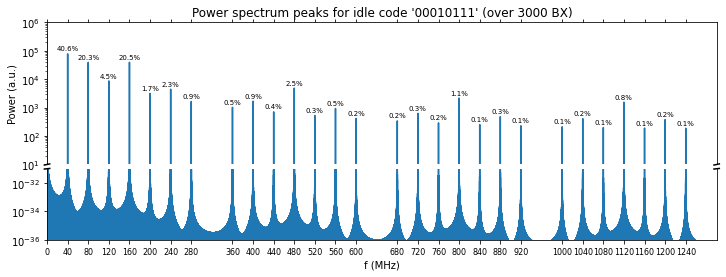

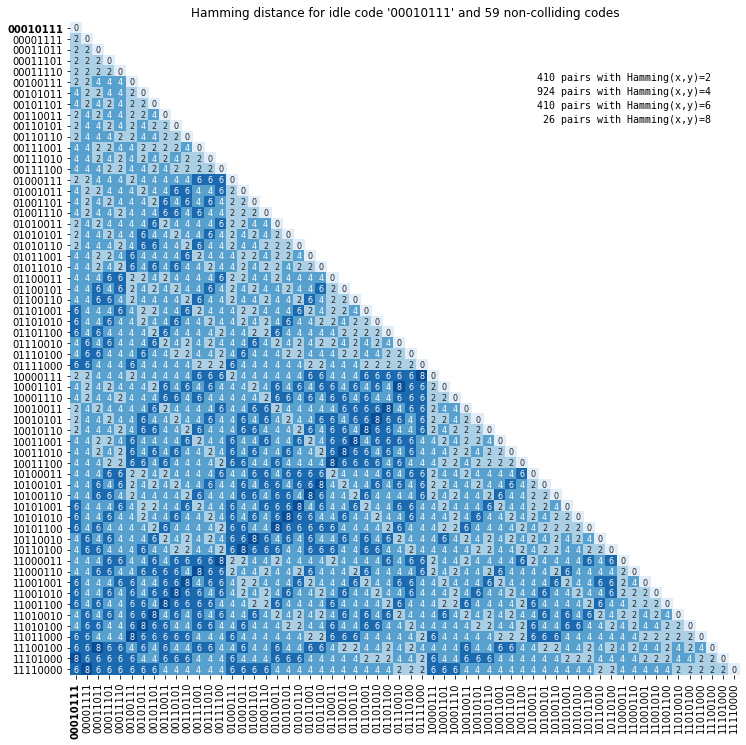

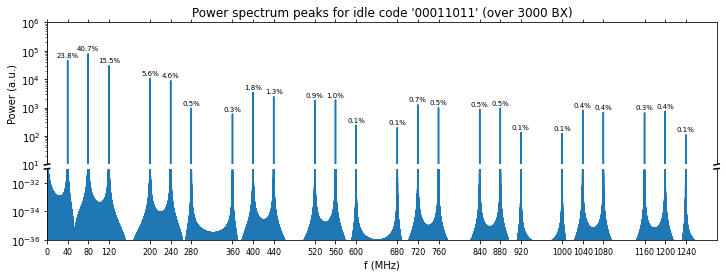

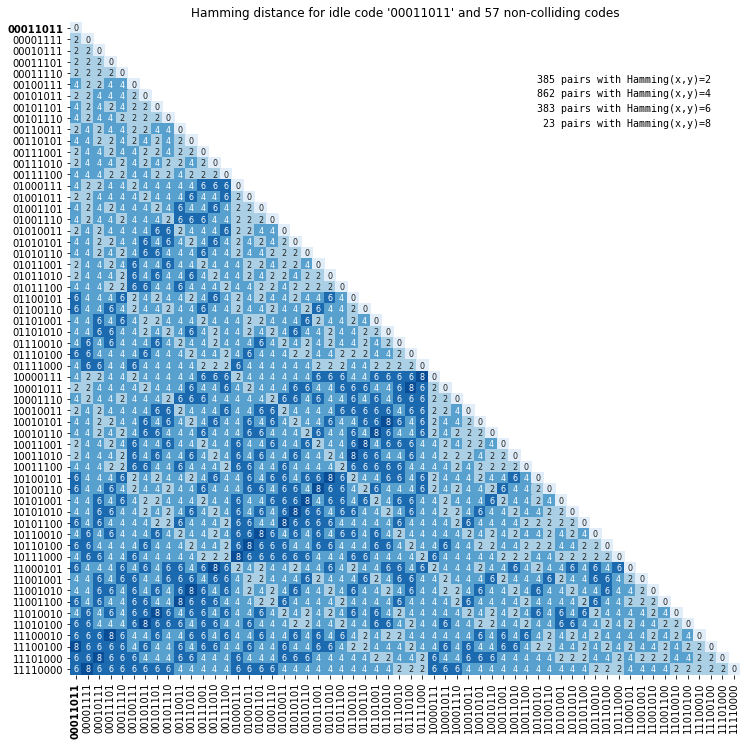

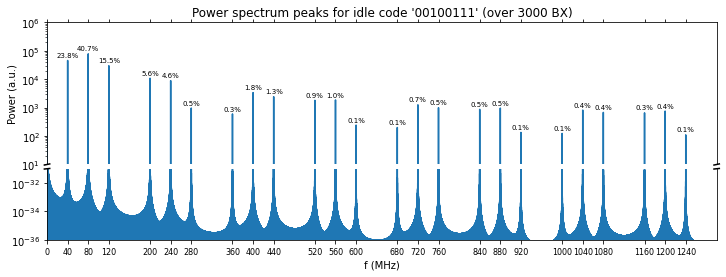

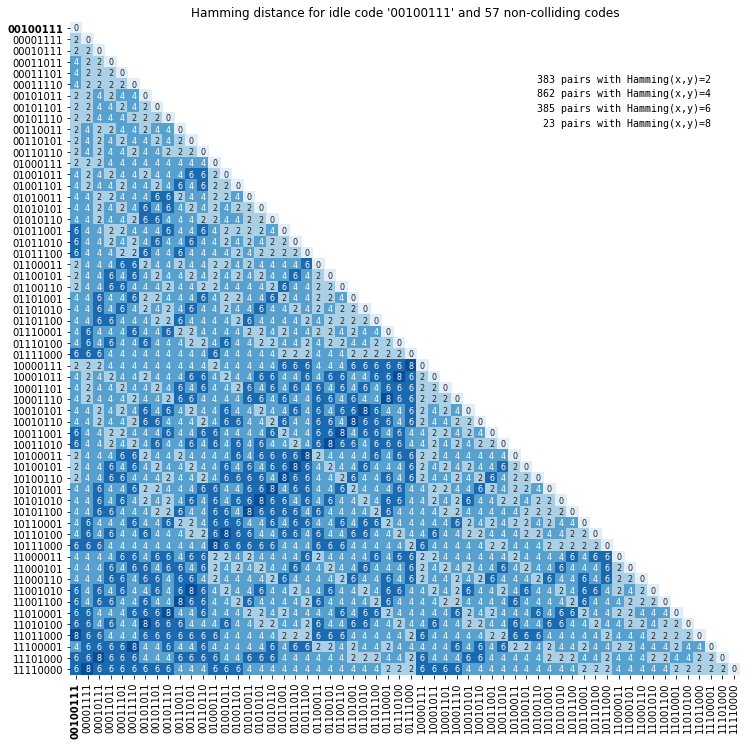

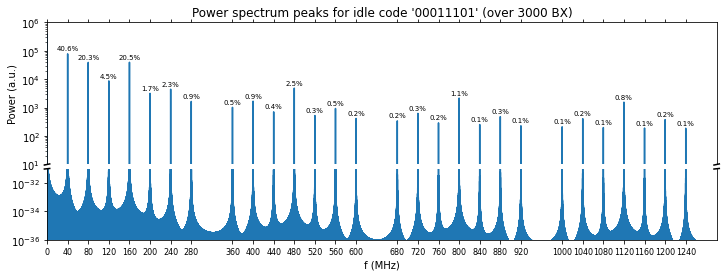

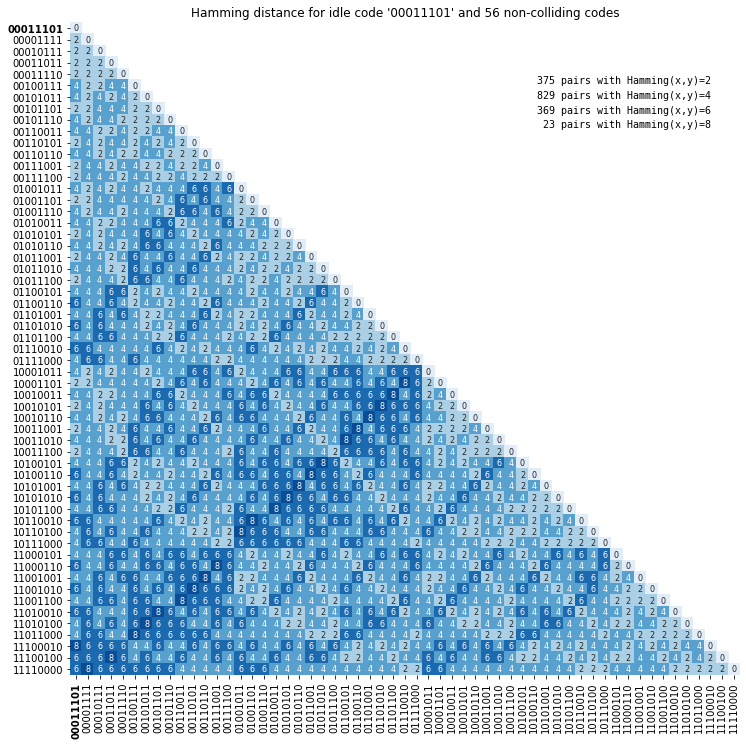

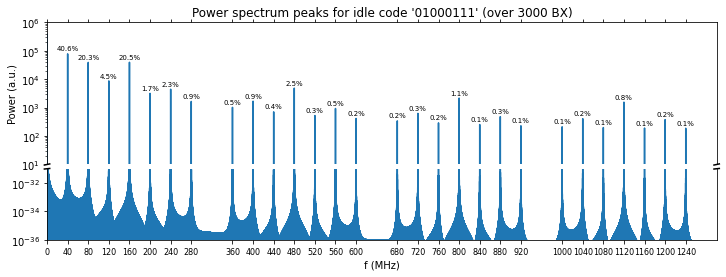

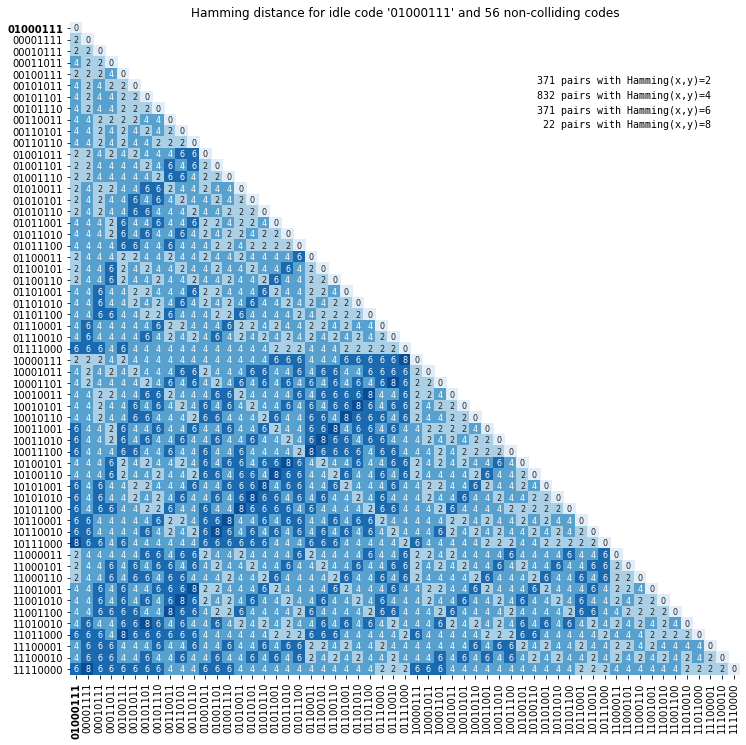

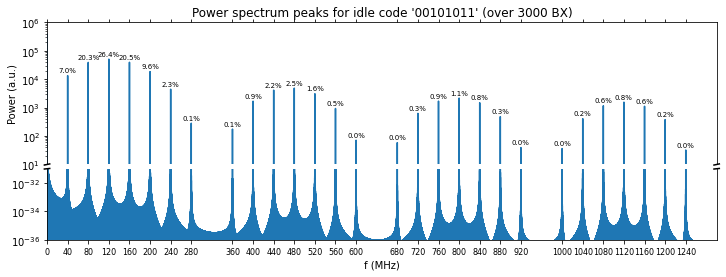

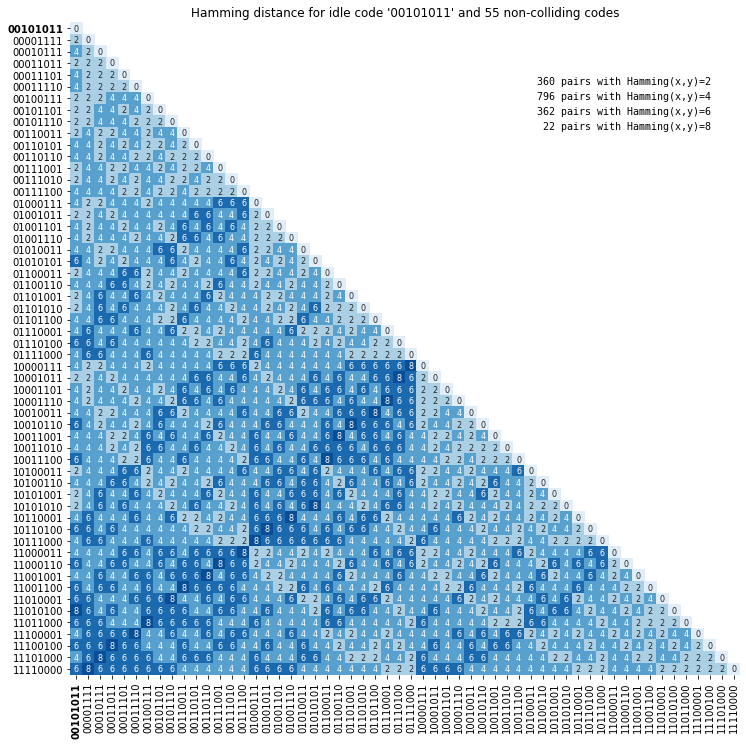

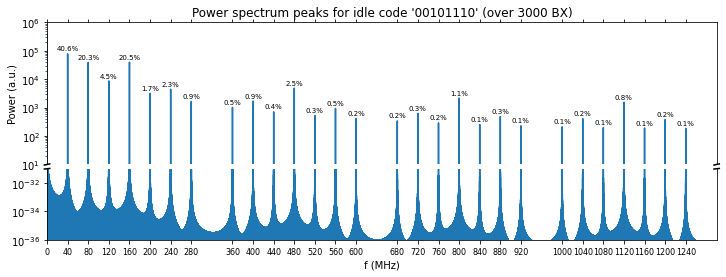

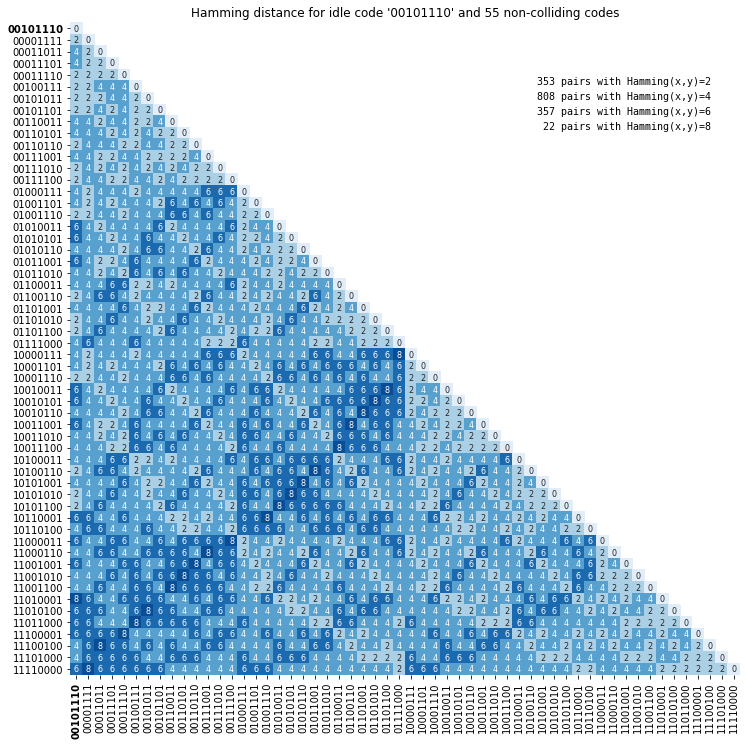

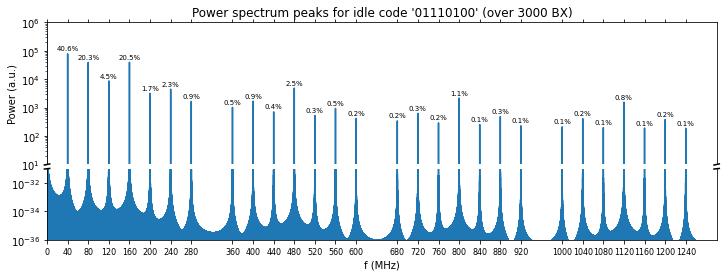

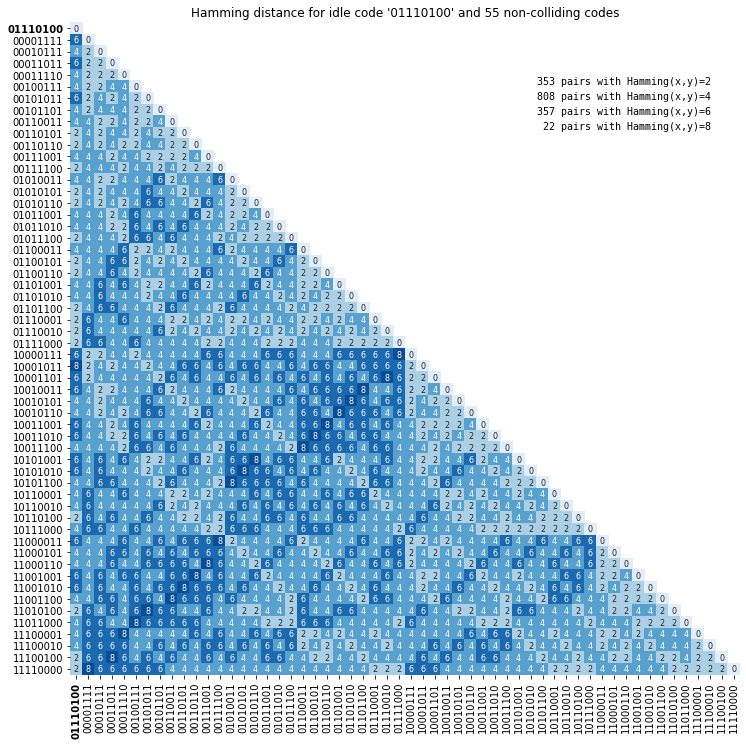

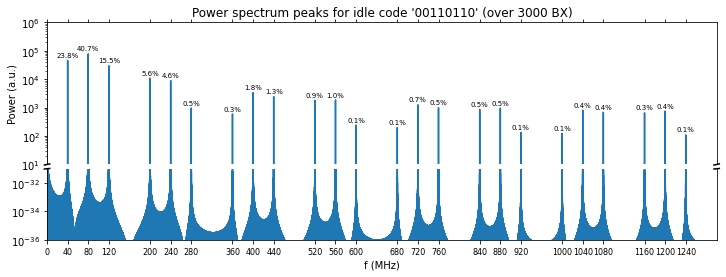

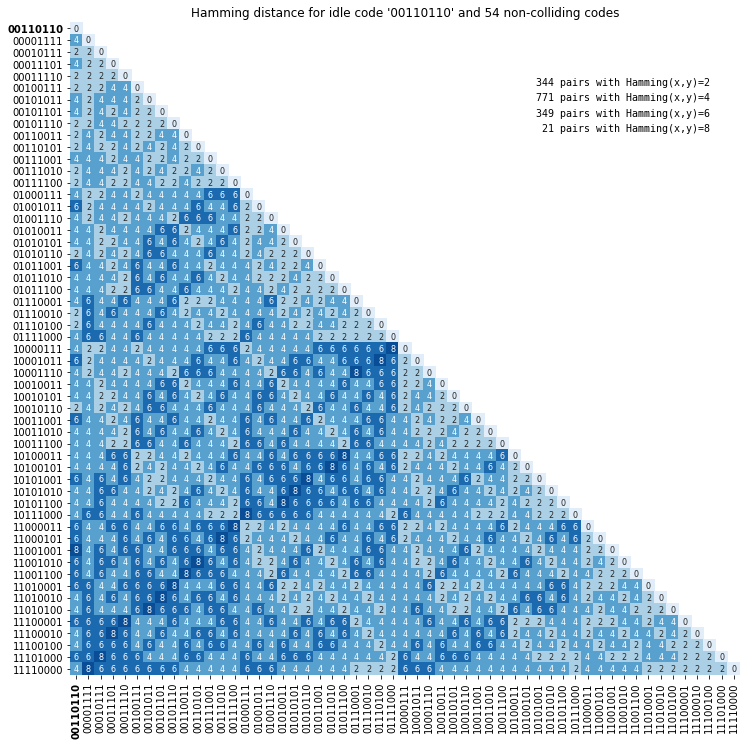

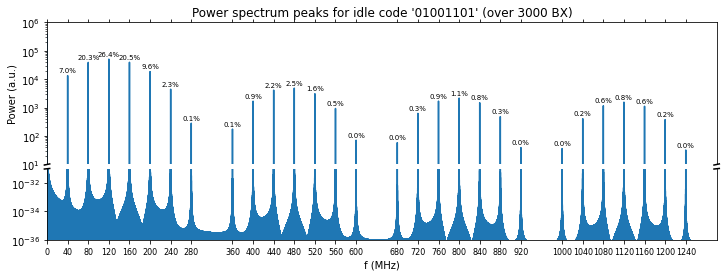

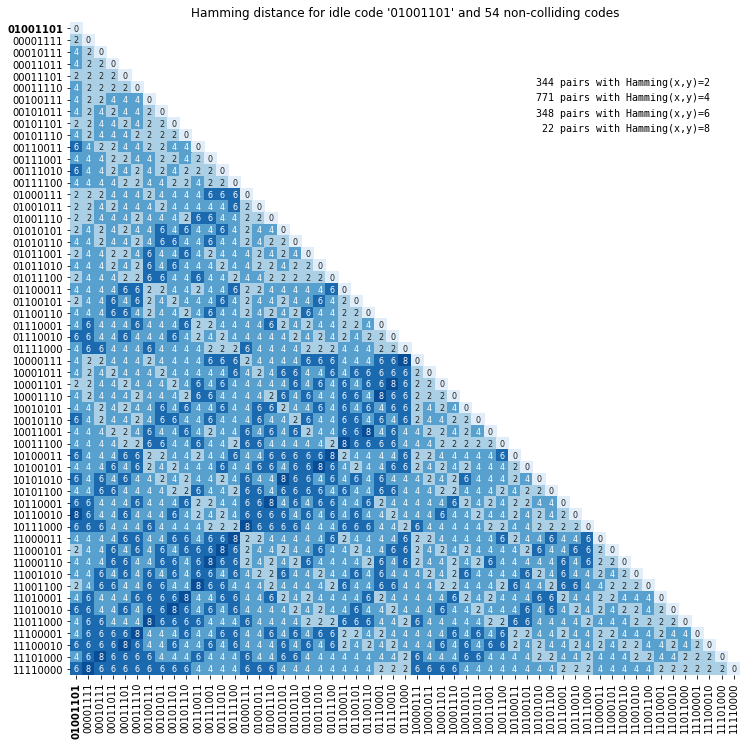

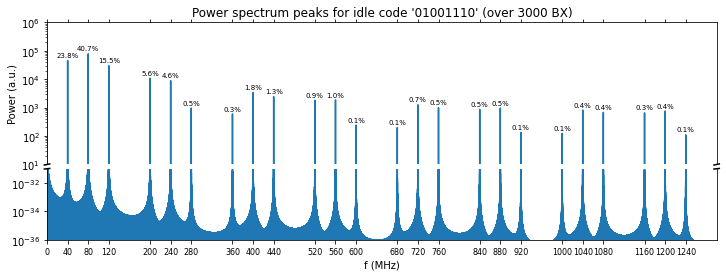

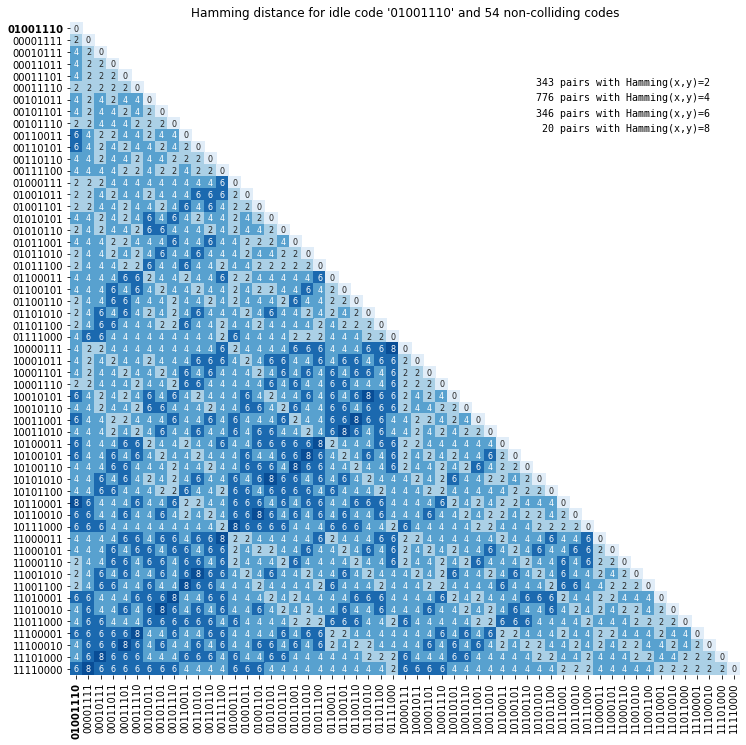

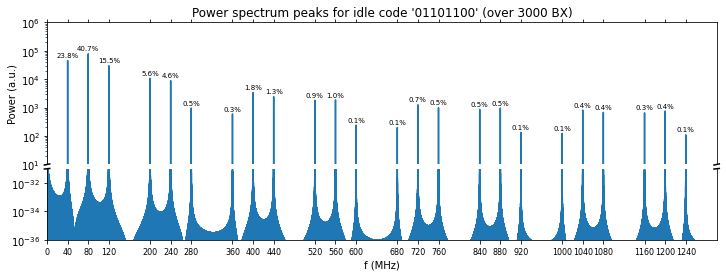

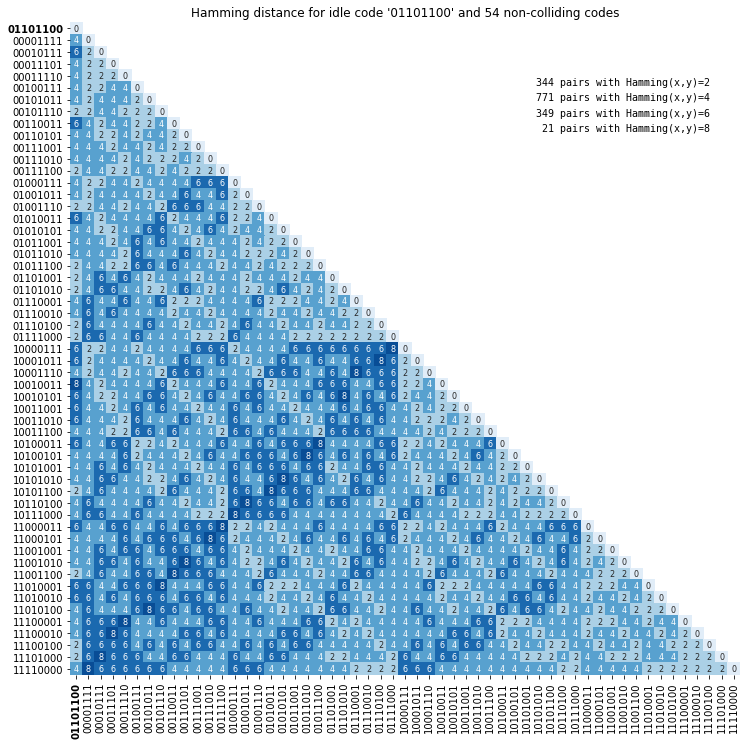

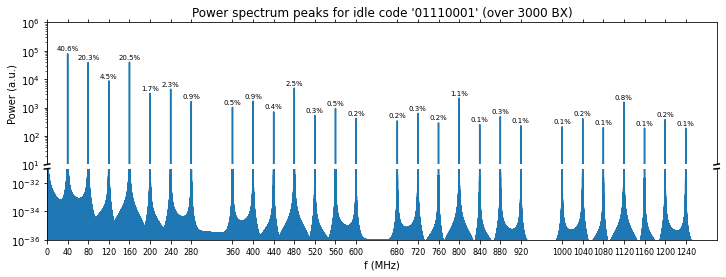

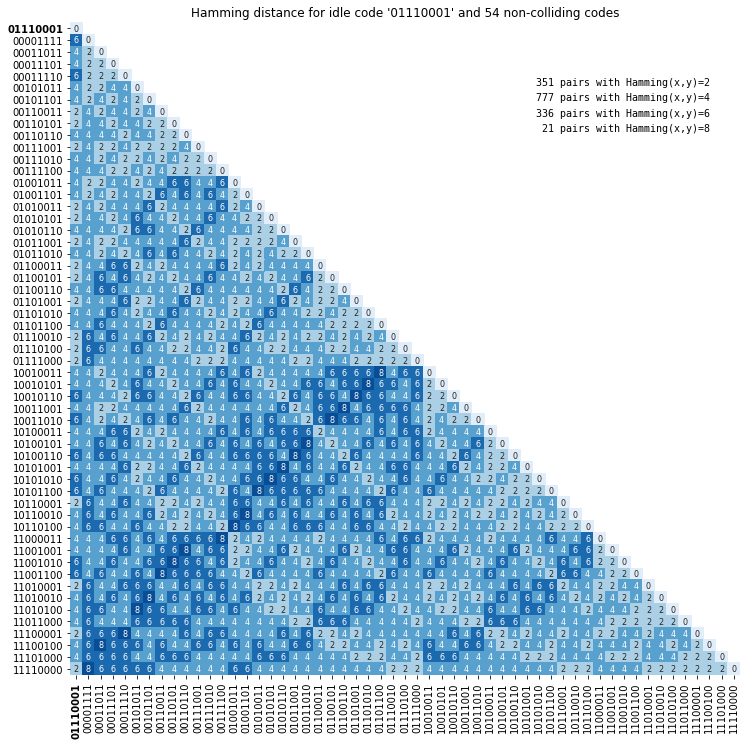

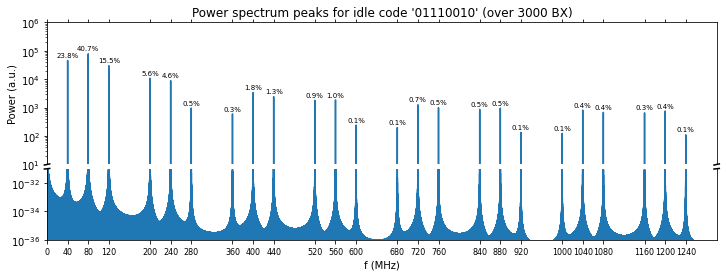

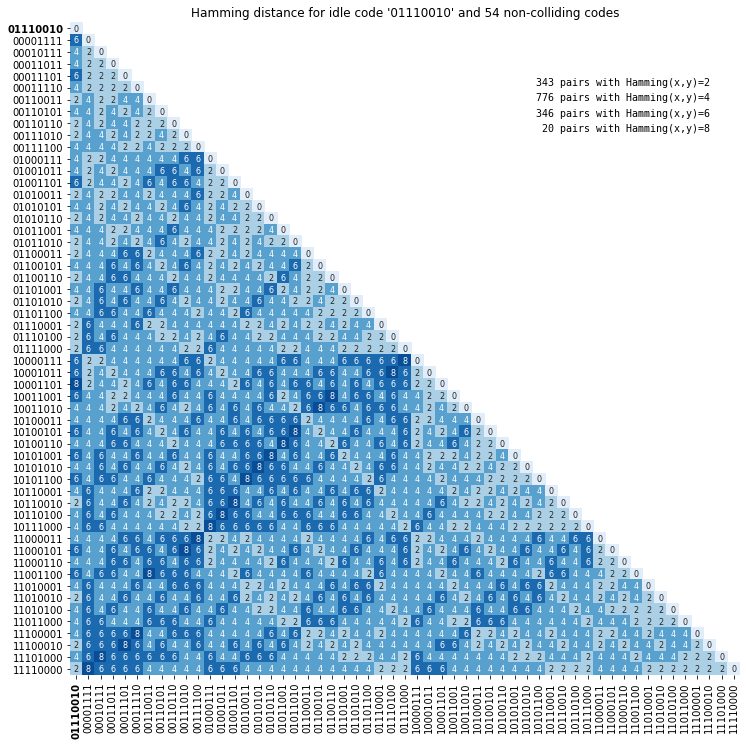

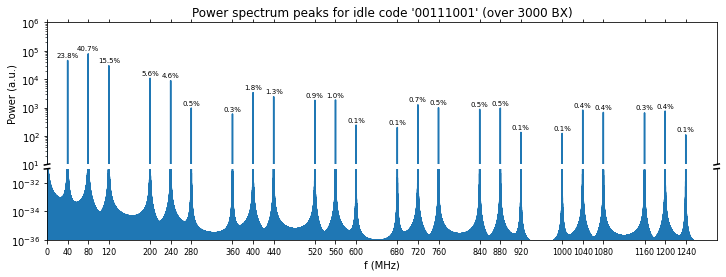

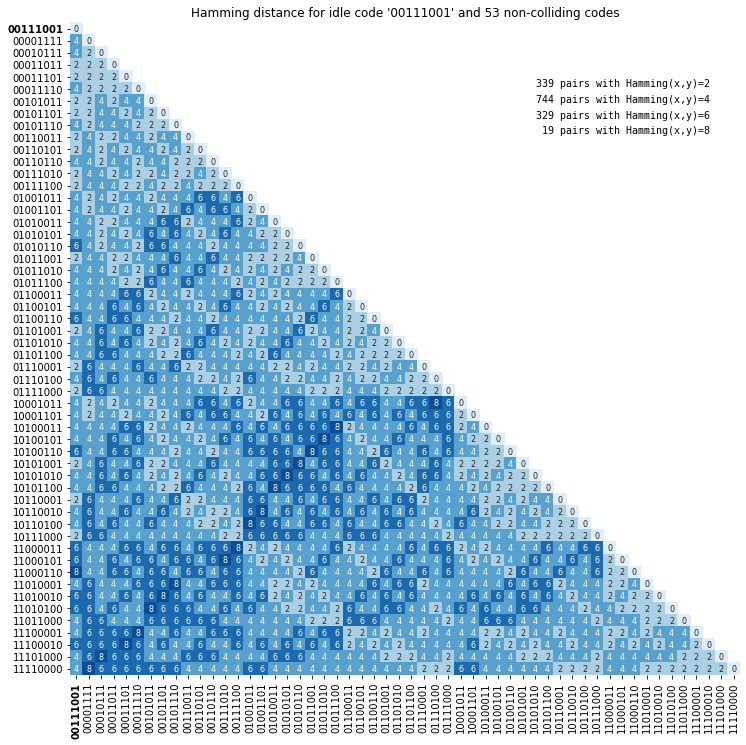

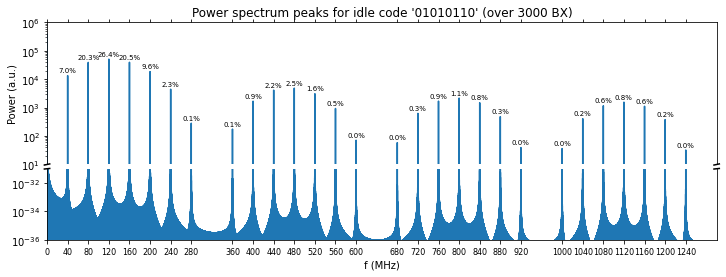

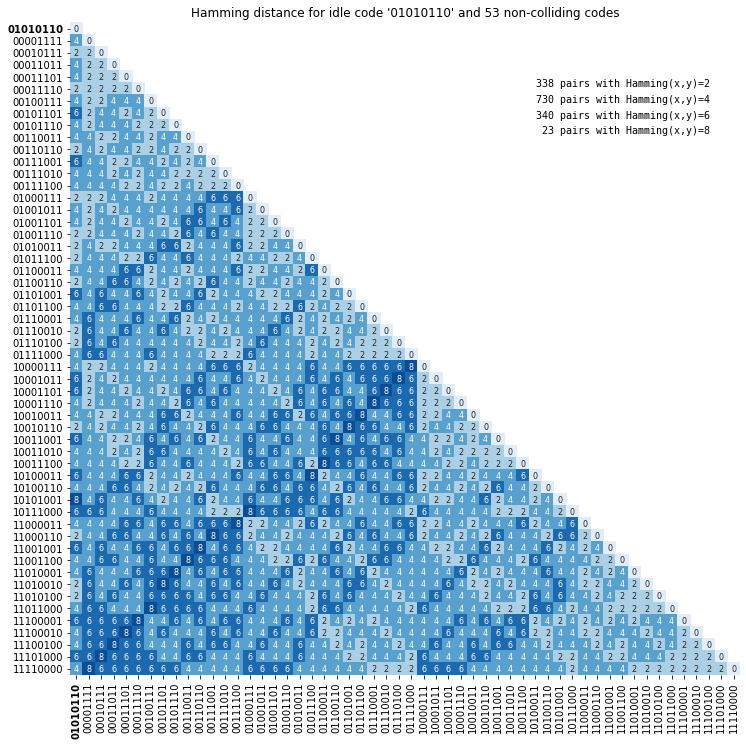

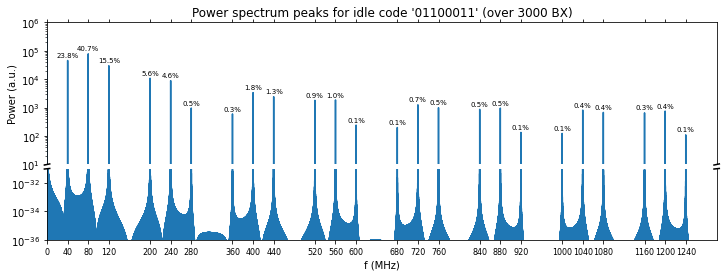

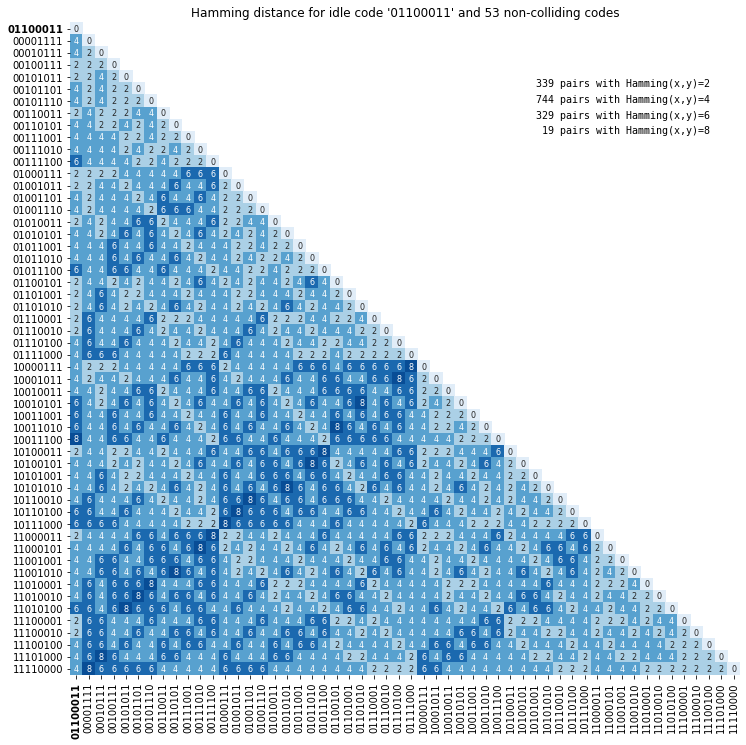

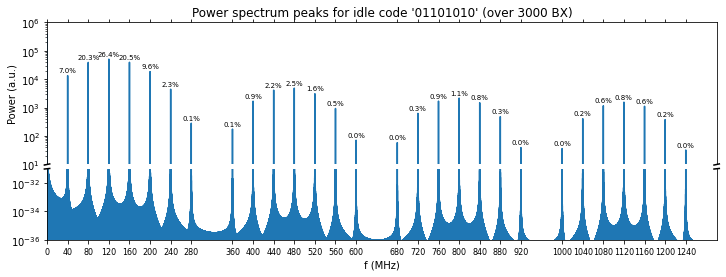

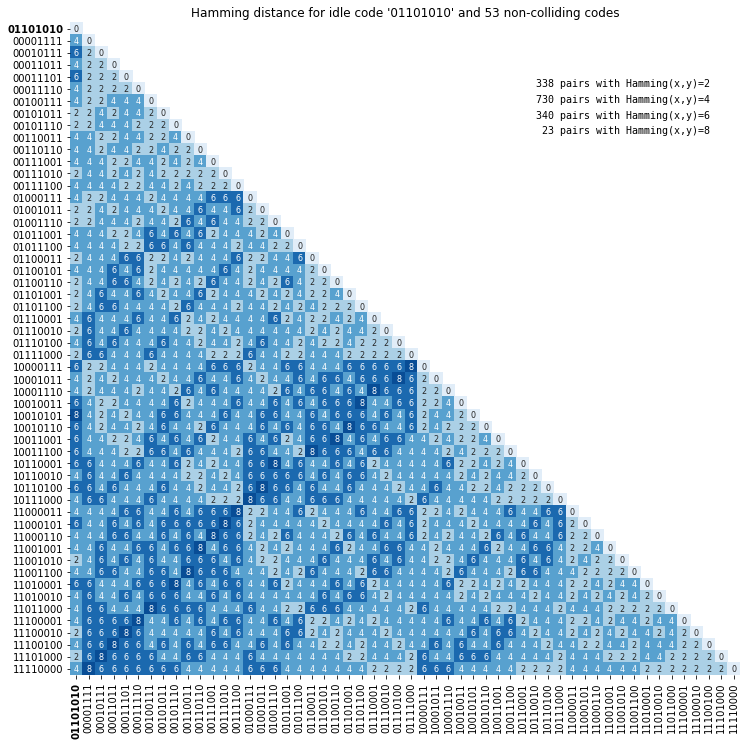

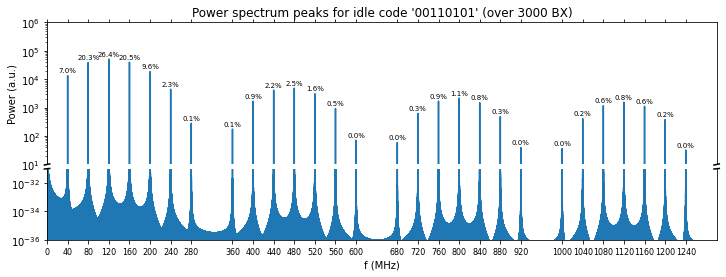

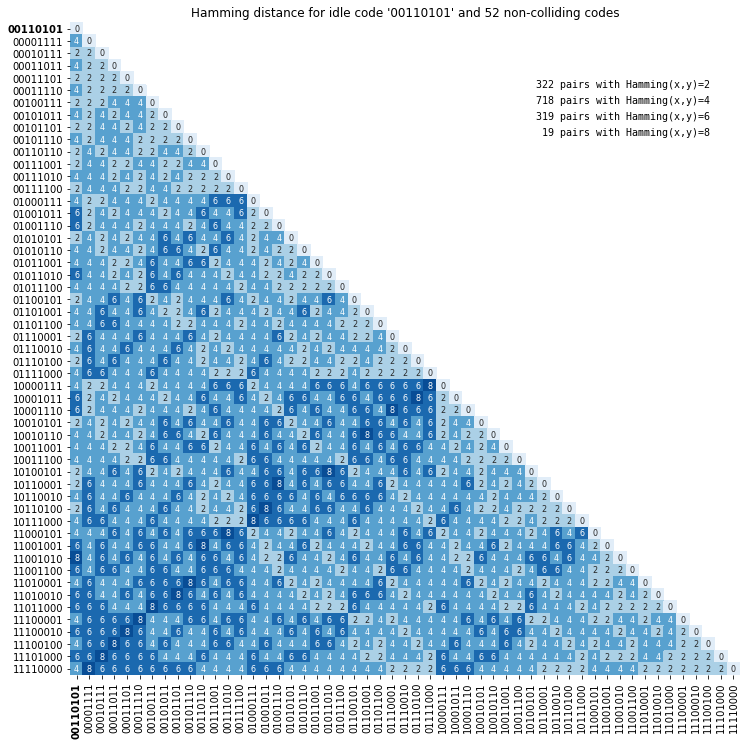

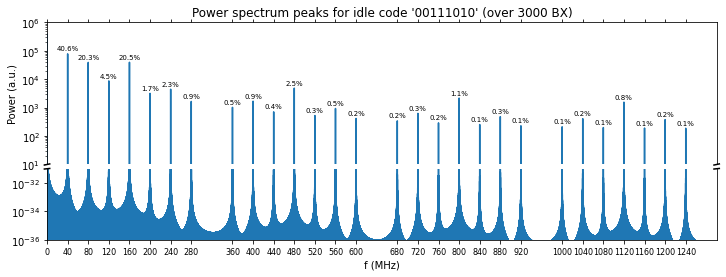

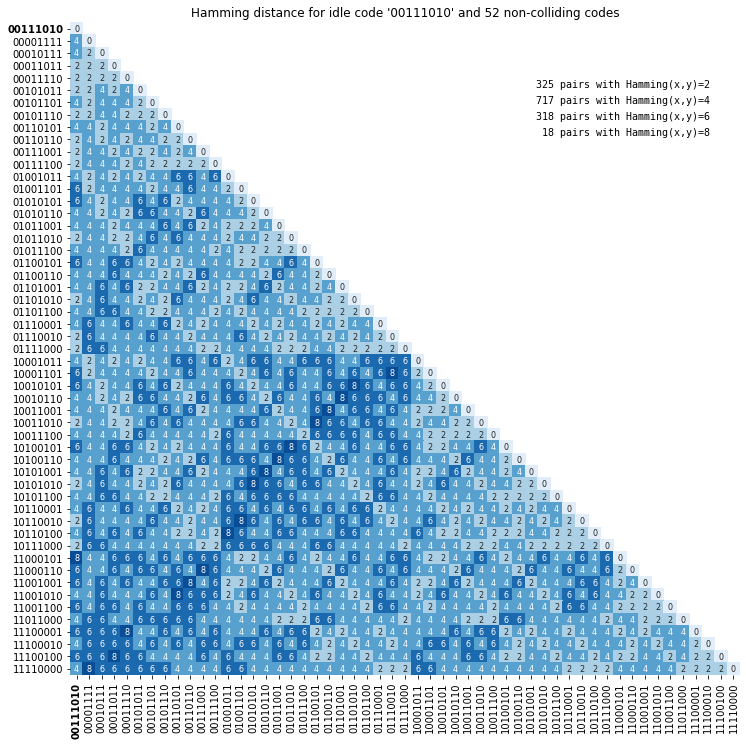

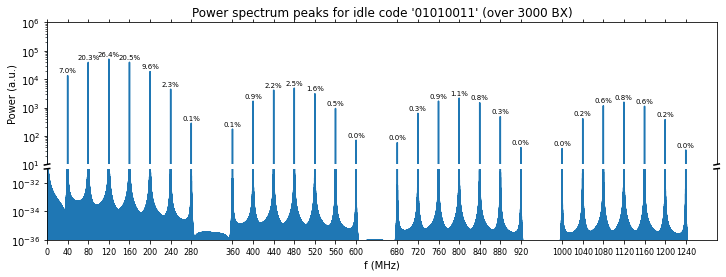

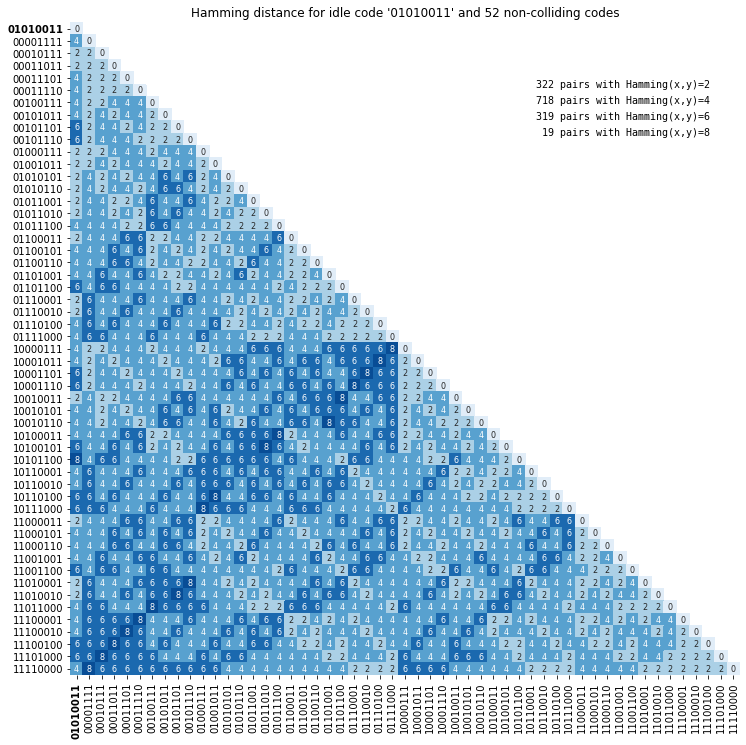

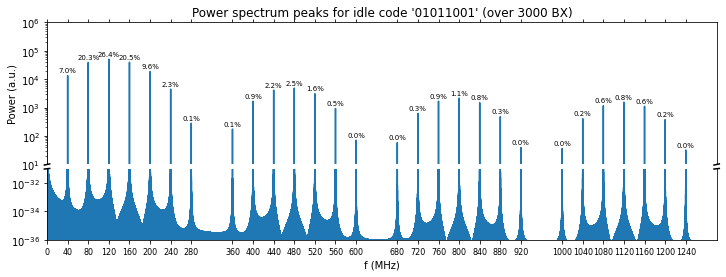

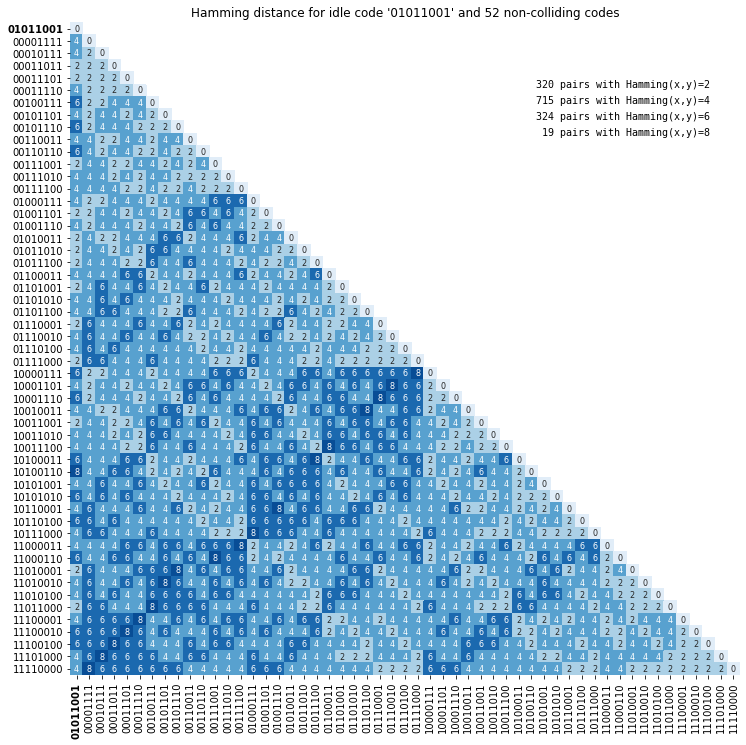

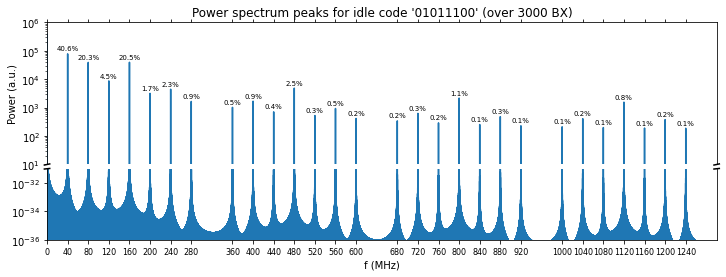

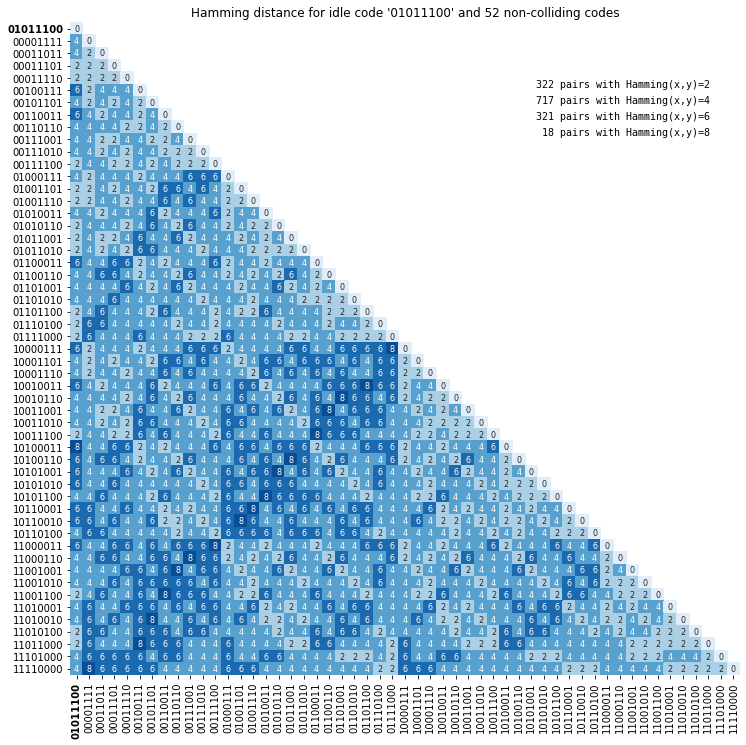

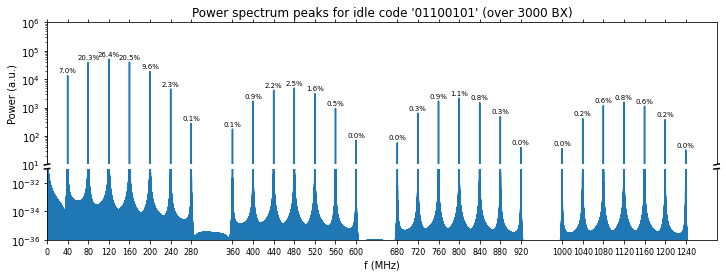

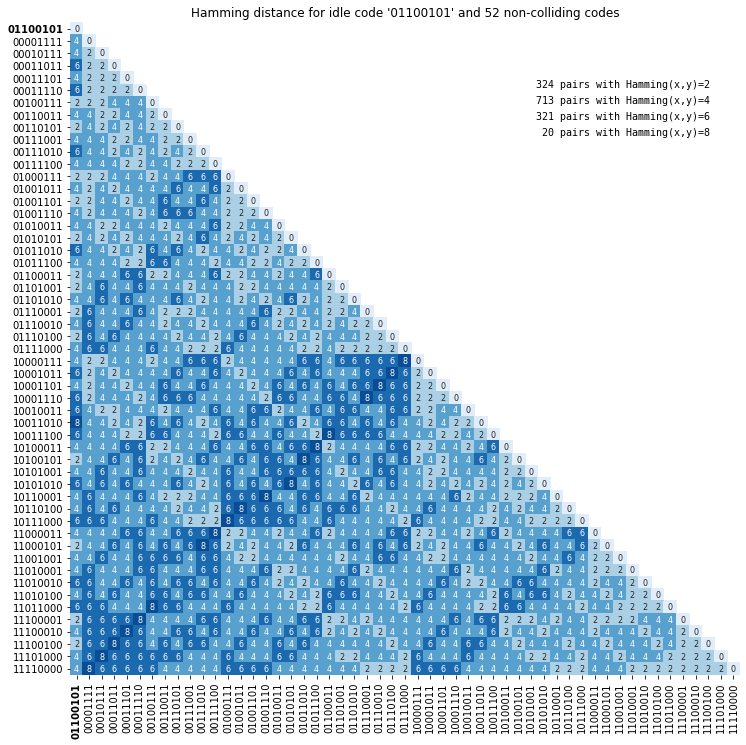

In [21]:
for kCode, survivors in results:
    processKCode(kCode)
    processDistances(kCode, survivors)

## Choosing the codes for HGCAL
The codes that we expect to need in order to encode all the commands and an estimate of their frequencies can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1tJ6jy9zY0_Fhr_WKaKF9yIxai9-_wcVbd4EMeB95Iz4/edit?usp=sharing).

### Rates
There are basically 5 classes of rates:
1. MHz
    - `Idle` ~ 38 MHz
    - `L1A`~ 1 MHz
    - `PreL1A` ~ 1 MHz
1. 10 kHz
    - `L1A+PreL1A` ~ 25 kHz
    - `OrbitSync` ~ 11 kHz
1. 100 Hz
    - `OrbitSync+L1A` ~ 280 Hz
    - `OrbitSync+PreL1A` ~ 280 Hz
1. 10 Hz
    - `NZS+L1A` ~ 10 Hz
    - `CalPulseInt` ~ 10 Hz
    - `CalPulseExt` ~ 10 Hz
    - `OrbitSync+L1A+PreL1A` ~ 7 Hz
1. sub-Hz
    - `NZS+L1A+PreL1A` ~ 0.25 Hz
    - `CalPulseInt+L1A` ~ 0.25 Hz
    - `CalPulseInt+PreL1A` ~ 0.25 Hz
    - `CalPulseExt+L1A` ~ 0.25 Hz
    - `CalPulseExt+PreL1A` ~ 0.25 Hz
    - `OrbitCounterReset+OrbitSync` ~ 0.01 Hz *
    - `EventCounterReset` ~ 0.01 Hz *
    - `EventBufferClear` ~ 0.01 Hz *
    - `LinkResetROCT` ~ 0.01 Hz *
    - `LinkResetROCD` ~ 0.01 Hz *
    - `LinkResetECONT` ~ 0.01 Hz *
    - `LinkResetECOND` ~ 0.01 Hz *
    - `CalPulseInt+L1A+PreL1A` < 0.01 Hz
    - `CalPulseExt+L1A+PreL1A` < 0.01 Hz

Codes marked with a * are sent in periods where it can be guaranteed that there is nothing else (other than idles) on the line.

### Idles faking other codes

While `Resets` are very unfrequent that may not be reason enough to think that it's ok to have small `Hamming(Idle, Reset)`.

The choice of Hamming distance between `Idle` and such other codes should be related to how long we expect recovery action to last in case of a spurious `Idle-to-X` mutation.

Some ordered thoughts (from worst to not so bad):
  1. `Idle -> CalPulse*` - **Terrible**: can produce fake physics in localised parts of the detector.
  1. `Idle -> EventBufferClear, ChipSync` - These can only have **terrible** consequences but haven't been throught through.
  1. `Idle -> LinkResetECON*` - **Bad**: it is unclear what BE can do if the ECON "spontaneously" resets the link.
  1. `Idle -> L1A*, PreL1A*` - **Bad**: we'll eventually get out of sync. Perhaps can be recovered if the ROCs+ECONs belonging together all see this but it would require the BE to do some gymnastics that are not presently foreseen
  1. `Idle -> OrbitSync*` - **Bad**: it's worse than 4) because it's for a large amount of events. It's better than 6) because there's one every orbit.
  1. `Idle -> *CounterReset` - **Sort of bad**: they would "only" require another `CounterReset` to be sent and the BE could possibly mask this to some extent.
  1. `Idle -> LinkResetROC*` - Would just lose data if both ROC and ECON get it.

In [22]:
# Assume we need 32 codes (of which 6 spare) in the book.
# This means that the codebook will need to have the kCode and 26+6-1=31 more codes
neededAmountOfCodes = 31
from scipy.special import comb
for kCode, codes in results:
    bookCombinations = comb(len(codes),neededAmountOfCodes)
    print(f'For kCode = {kCode} there are {bookCombinations:g} combinations of {neededAmountOfCodes} codes out of {len(codes)} codes.')

For kCode = 00010111 there are 5.53173e+16 combinations of 31 codes out of 59 codes.
For kCode = 00011011 there are 1.22209e+16 combinations of 31 codes out of 57 codes.
For kCode = 00100111 there are 1.22209e+16 combinations of 31 codes out of 57 codes.
For kCode = 00011101 there are 5.57444e+15 combinations of 31 codes out of 56 codes.
For kCode = 01000111 there are 5.57444e+15 combinations of 31 codes out of 56 codes.
For kCode = 00101011 there are 2.48859e+15 combinations of 31 codes out of 55 codes.
For kCode = 00101110 there are 2.48859e+15 combinations of 31 codes out of 55 codes.
For kCode = 01110100 there are 2.48859e+15 combinations of 31 codes out of 55 codes.
For kCode = 00110110 there are 1.08593e+15 combinations of 31 codes out of 54 codes.
For kCode = 01001101 there are 1.08593e+15 combinations of 31 codes out of 54 codes.
For kCode = 01001110 there are 1.08593e+15 combinations of 31 codes out of 54 codes.
For kCode = 01101100 there are 1.08593e+15 combinations of 31 cod

In [23]:
print(comb(59,2)*0.5 * comb(59-2,2)*0.5 * comb(59-2-2,2)*0.5 * comb(59-2-2-2,4)*0.5, comb(59,10))

74215995885281.25 62828356305.0


## 🚧 - Work in progress
Brain dump of ideas to solve the combinatorial problem:
- Describe the code relations in a graph and find the [subgraph with the largest sum](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.matching.max_weight_matching.html) of Hamming distances.
- Perform a form of [search in a parameter space](https://simonblanke.github.io/Hyperactive/#/./reference).
- Perform a form of [hill-climbing](https://codereview.stackexchange.com/questions/90505/approximate-250-over-100-permutation-best-fitting-certain-criteria) or [simulated annealing](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html) to add codes.
- State the problem as a form of binary programming and solve with [convex optimization](https://towardsdatascience.com/integer-programming-in-python-1cbdfa240df2) or [linear programming](https://towardsdatascience.com/linear-programming-and-discrete-optimization-with-python-using-pulp-449f3c5f6e99).

Some of the above do not lend themselves easily to the special role of the `kCode` (`Idle` code) or the very different frequencies that some codes (like `L1A` and `PreL1A`) will have.

E.g., one thing that seems clear from exploring the Hamming distances matrices is that any triangle in the graph of distances has a maximum sum of 16.

This means that when considering the triangle among `Idle` (~ 38 MHz,) `L1A` (~ 1 MHz,) and `PreL1A` (same rate as `L1A`,) which are the most frequent codes, the best case would be:
- Hamming(`Idle`,`L1A`) = 6
- Hamming(`Idle`,`PreL1A`) = 6
- Hamming(`L1A`,`PreL1A`) = 4

Other solutions, like (8,6,2) or (6,4,6) would not maximize the distance to `Idle`.

Another observation from studying the Hamming distances matrices is that whenever including all triangles with Hamming distance sum of 16, one ends up including all the codes. I.e., there is no free lunch.

In [24]:
# https://networkx.github.io/documentation/stable/index.html
import random
import networkx as nx
(kCode, codes) = largest_codebook_result
# codeBook = [kCode] + codes
codeBook = [kCode] + random.sample(codes, 15) # take only a random subsample
G = nx.Graph()
for (c1, c2) in product(codeBook, repeat=2):
    if c1 != c2: # so as to not add zero-distance useless edges
        G.add_edge(c1, c2, weight=hammingAllCodes[(c1, c2)])

Name: 
Type: Graph
Number of nodes: 16
Number of edges: 120
Average degree:  15.0000
480


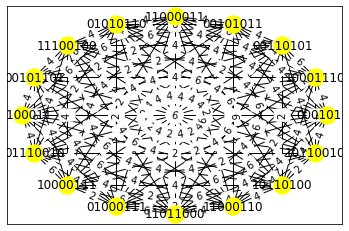

In [25]:
print(nx.info(G))
pos = nx.circular_layout(G) 
nx.draw_networkx(G, pos, node_color='yellow')
weights = nx.get_edge_attributes(G,'weight')
_ = nx.draw_networkx_edge_labels(G, pos, edge_labels = weights)
print(sum(weights.values()))

In [26]:
cliques = nx.clique.enumerate_all_cliques(G)

def triangleDists(triangle):
    (c1, c2, c3) = triangle
    dists = (hammingAllCodes[(c1,c2)], hammingAllCodes[(c1,c3)], hammingAllCodes[(c2,c3)])
    return dists

triangles = [ (tuple(clique), triangleDists(clique)) for clique in cliques if len(clique)==3 ]

In [27]:
sixteeners = [triangle for triangle in triangles if sum(triangle[1])==16]
pprint(sixteeners)
import itertools as it
enchiridion = set(it.chain(*[sixteener[0] for sixteener in sixteeners]))
pprint(enchiridion)

[(('00010111', '00101011', '11100100'), (4, 6, 6)),
 (('00010111', '00101011', '11011000'), (4, 6, 6)),
 (('00010111', '11100100', '11011000'), (6, 6, 4)),
 (('00010111', '00101101', '11011000'), (4, 6, 6)),
 (('00010111', '10100011', '11011000'), (4, 6, 6)),
 (('10001110', '00110101', '11000011'), (6, 4, 6)),
 (('10001110', '00110101', '01110010'), (6, 6, 4)),
 (('10001110', '00110101', '11011000'), (6, 4, 6)),
 (('10001110', '00101101', '01110010'), (4, 6, 6)),
 (('00110101', '00101011', '11011000'), (4, 6, 6)),
 (('00110101', '00101011', '11000110'), (4, 6, 6)),
 (('00110101', '11000011', '11011000'), (6, 6, 4)),
 (('00110101', '10100011', '11011000'), (4, 6, 6)),
 (('00110101', '10000111', '11011000'), (4, 6, 6)),
 (('00110101', '01000111', '11011000'), (4, 6, 6)),
 (('00110101', '11011000', '11000110'), (6, 6, 4)),
 (('00101011', '11000011', '10110100'), (4, 6, 6)),
 (('00101011', '01010110', '11100100'), (6, 6, 4)),
 (('00101011', '01010110', '11011000'), (6, 6, 4)),
 (('00101011

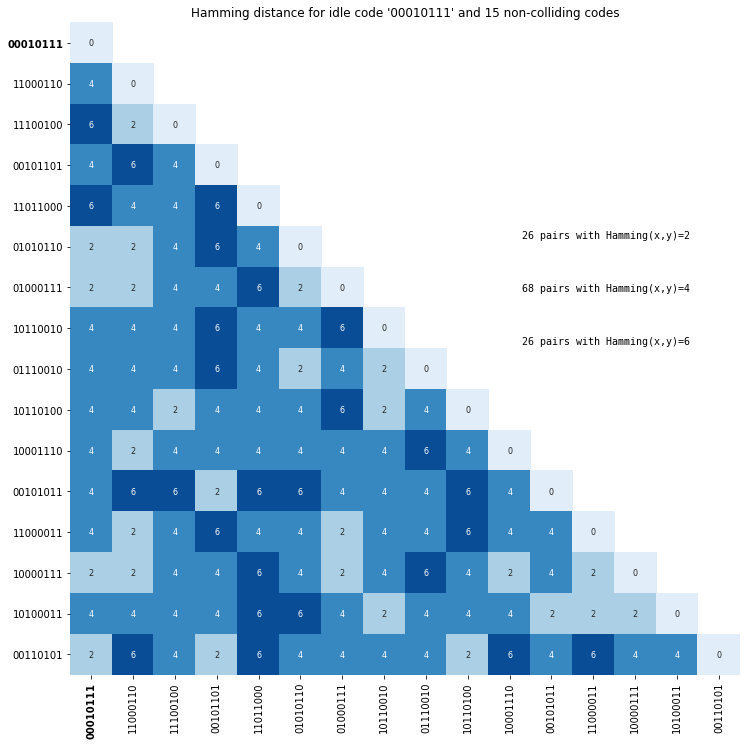

In [28]:
processDistances(kCode, list(enchiridion-set([kCode])) )

In [29]:
from hyperactive import Hyperactive
from time import sleep
(kCode, codes) = largest_codebook_result

def optTask(config, X, y):
    # get the list of codes based on something from the config
    # build the graph
    # get the distance
#     sleep(10)
    return config['fakeParam']

optConfig = {
    optTask: {
        'fakeParam': range(500)
    }
}

opt = Hyperactive(np.empty([10]), np.empty([10]), memory='short')
opt.search(optConfig, optimizer='EvolutionStrategy')


Set random start position



best para = {'fakeParam': 496}
score     = 496 



In [30]:
# 🚧 This is where we would construct the actual codes based on frequency groups
from operator import itemgetter

def triangleDist(codes):
    return sum(tuple(hammingAllCodes[(c1,c2)] for (c1,c2) in product(codes, repeat=2)))

def makeCodeBook(kCode, codes, bookLength = 5):
    # Seed with the kCode
    book = [kCode]
    # Consider adding two more that maximize the total Hamming distance
    distances = [ (subset,triangleDist([kCode]+list(subset))) for subset in product(codes, repeat=3) ]
    distances.sort(key=itemgetter(1), reverse=True)
    
    print(distances)[0]
    
#     # print(len(codes),codes)
#     pairs = product(codes, repeat=2)
#     distances = [ ((x, y), hamming(x,y)) for x, y in pairs if int(x) < int(y)]
#     distances.sort(key=itemgetter(1))

#     print(distances[0])
#     smallestHammingCodePair, smallestHammingDistance = distances[0]

#     if smallestHammingDistance >= dist_threshold:
#         return codes

#     # decide which code in the pair to drop
#     worstCode = smallestHammingCodePair[0]
#     codes.remove(worstCode)
#     return makeCodeBook(codes, dist_threshold)

(kCode, codes) = largest_codebook_result
c = makeCodeBook(kCode, codes.copy(), 31)
print(len(c))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



TypeError: 'NoneType' object is not subscriptable